### Финальное задание
##### Предметная область: Игра Dota 2

In [1]:
import time
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as pyplot

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [97]:
train_data = pd.read_csv('./data/features.csv', index_col = 'match_id')
train_data.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,1,11,4,3,1058,996,12,0,0,6,42,4,1085,986,12,0,0,4,21,5,2052,1536,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,0,5,39,5,1960,1384,16,0,0,8,88,3,640,566,1,0,1,5,79,3,720,1350,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,0,9,22,5,2305,2028,19,1,1,10,66,3,1024,959,19,0,1,10,86,3,755,620,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,0,6,96,5,1878,1174,17,0,0,6,48,3,732,1468,22,0,0,10,15,4,1681,1051,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,0,8,26,3,704,586,1,0,2,9,69,3,1169,1665,20,1,0,7,22,3,1055,638,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


#### Подход 1: градиентный бустинг "в лоб"

#### 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [3]:
final_feature_names = ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_dire', 'barracks_status_radiant']
X_train = train_data.drop(columns = final_feature_names)
y_train = train_data['radiant_win']

#### 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных?

In [4]:
n_rows = len(X_train)
counts = X_train.describe().T['count']
counts_na = counts[counts < n_rows]
counts_na.sort_values().apply(lambda count: (n_rows - count) / n_rows)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
Name: count, dtype: float64

 #### Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

- first_blood_player2 (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев
- radiant_flying_courier_time (время приобретения предмета "flying_courier") - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры

#### 3. Замените пропуски на нули с помощью функции fillna()

In [5]:
X_train.fillna(0, inplace = True)

#### 4. Какой столбец содержит целевую переменную? Запишите его название

In [6]:
'radiant_win'

'radiant_win'

#### 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". 
- Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True) 
- Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев. 

In [7]:
def fit(fold, X, y, n_estimators):
    start_time = datetime.datetime.now()
    
    model = GradientBoostingClassifier(n_estimators = n_estimators, random_state = 241)
    val_scores = cross_val_score(estimator = model, cv = fold, scoring = "roc_auc", X = X, y = y)
    
    time_elapsed = datetime.datetime.now() - start_time
        
    mean_score = np.mean(val_scores)
    print('n_estimators: {}, mean score: {}, time elapsed: {}, '.format(n_estimators, mean_score, time_elapsed))
    return mean_score

In [8]:
scores = {}
fold = KFold(n_splits = 5, shuffle = True, random_state = 241)

for i in [10, 20, 30, 50, 100, 250]:
    scores[i] = fit(fold, X_train, y_train, i)

n_estimators: 10, mean score: 0.6643877206345741, time elapsed: 0:00:22.785754, 
n_estimators: 20, mean score: 0.6828535735340823, time elapsed: 0:00:35.968717, 
n_estimators: 30, mean score: 0.6894962060591201, time elapsed: 0:00:49.443498, 
n_estimators: 50, mean score: 0.6974548316948366, time elapsed: 0:01:20.792426, 
n_estimators: 100, mean score: 0.7063262181631453, time elapsed: 0:02:38.656201, 
n_estimators: 250, mean score: 0.7156382028679349, time elapsed: 0:06:31.443882, 


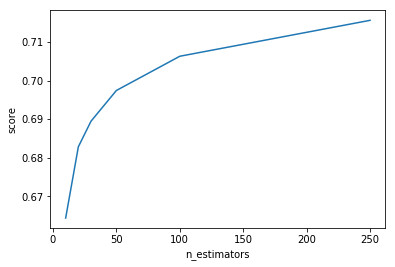

In [9]:
pyplot.plot(scores.keys(), scores.values())
pyplot.xlabel('n_estimators')
pyplot.ylabel('score')
pyplot.show()

#### Долго ли настраивались классификаторы? 

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:00:49. Показатель метрики качества AUC-ROC в таком случае равен 0.69.

#### Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

Увеличение количества деревьев увеличивает показатель метрики AUC-ROC, приближая его к значению 0.72. 

Для достижения большего качества имеет смысл использовать более 30 деревьев. Для ускорения обучения можно использовать не всю выборку, а ее подмножество — например, половину. 
Также можно уменьшить глубину деревьев (max_depth).

#### Подход 2: логистическая регрессия

#### 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга.

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [11]:
c_param_pows = range(-4, 6)

def plot_scores(c_values, scores):
    pyplot.plot(c_values, scores)
    pyplot.xlabel('log(c)')
    pyplot.ylabel('score')
    pyplot.show()

def fit_log_reg_with_c(fold, X, y, c):
    start_time = datetime.datetime.now()
    
    model = LogisticRegression(C = c, random_state=241)
    scores = cross_val_score(model, X, y, cv = fold, scoring = 'roc_auc')
    
    time_elapsed = datetime.datetime.now() - start_time
    
    mean_score = np.mean(scores)
    print('Hyperparam C: {}, mean score: {}, time elapsed: {}, '.format(c, mean_score, time_elapsed))
    return mean_score

def fit_log_reg(X, y):
    scores = {}
    for c in [10.0 ** c for c in c_param_pows]:
        scores[c] = fit_log_reg_with_c(fold, X, y, c)       
    return scores

def print_max_log_reg_score(scores):
    max_score_c_param = max(log_reg_scores, key = log_reg_scores.get)
    print("C: {}, score: {}".format(max_score_c_param, log_reg_scores[max_score_c_param]))

In [12]:
log_reg_scores = fit_log_reg(X_train_scaled, y_train)

Hyperparam C: 0.0001, mean score: 0.7112501143920594, time elapsed: 0:00:04.440228, 
Hyperparam C: 0.001, mean score: 0.7161802463683579, time elapsed: 0:00:07.964099, 
Hyperparam C: 0.01, mean score: 0.716341462186996, time elapsed: 0:00:10.222438, 
Hyperparam C: 0.1, mean score: 0.7163100836533355, time elapsed: 0:00:10.568612, 
Hyperparam C: 1.0, mean score: 0.716306583645544, time elapsed: 0:00:10.595449, 
Hyperparam C: 10.0, mean score: 0.7163063399602339, time elapsed: 0:00:10.726892, 
Hyperparam C: 100.0, mean score: 0.7163062657792336, time elapsed: 0:00:10.610598, 
Hyperparam C: 1000.0, mean score: 0.7163062636530346, time elapsed: 0:00:10.620741, 
Hyperparam C: 10000.0, mean score: 0.7163062572998155, time elapsed: 0:00:10.650027, 
Hyperparam C: 100000.0, mean score: 0.7163062594192566, time elapsed: 0:00:10.677907, 


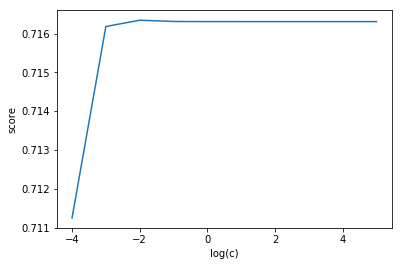

In [13]:
plot_scores(c_param_pows, log_reg_scores.values())

#### Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось?

In [14]:
print_max_log_reg_score(log_reg_scores)

C: 0.01, score: 0.716341462186996


#### Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.71. Это сравнимо с градиентным бустингом по 250 деревьям, при этом логистическая регрессия работает заметно быстрее.

#### 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 

Hyperparam C: 0.0001, mean score: 0.7112483906159718, time elapsed: 0:00:03.902487, 
Hyperparam C: 0.001, mean score: 0.7162355910206267, time elapsed: 0:00:07.026640, 
Hyperparam C: 0.01, mean score: 0.7164009506527343, time elapsed: 0:00:09.103607, 
Hyperparam C: 0.1, mean score: 0.7163737844721111, time elapsed: 0:00:09.477721, 
Hyperparam C: 1.0, mean score: 0.7163707526581122, time elapsed: 0:00:09.484819, 
Hyperparam C: 10.0, mean score: 0.7163704793048005, time elapsed: 0:00:09.464170, 
Hyperparam C: 100.0, mean score: 0.7163704962706652, time elapsed: 0:00:09.462752, 
Hyperparam C: 1000.0, mean score: 0.7163705301659757, time elapsed: 0:00:09.502900, 
Hyperparam C: 10000.0, mean score: 0.7163705301674705, time elapsed: 0:00:09.528650, 
Hyperparam C: 100000.0, mean score: 0.7163705280495243, time elapsed: 0:00:09.461455, 


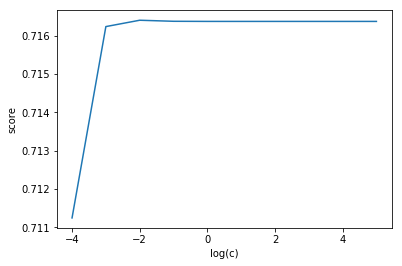

In [15]:
def clean_category(X):
    X_copy = X.copy()
    X_copy.drop('lobby_type', axis = 1, inplace = True)
    for i in range(1, 6):
        X_copy.drop(['r{}_hero'.format(i), 'd{}_hero'.format(i)], axis = 1, inplace = True)

    return X_copy

X_train_without_heroes = clean_category(X_train)

log_reg_scores = fit_log_reg(scaler.fit_transform(X_train_without_heroes), y_train)
plot_scores(c_param_pows, log_reg_scores.values())

#### Изменилось ли качество? Чем вы можете это объяснить?

In [16]:
print_max_log_reg_score(log_reg_scores)

C: 0.01, score: 0.7164009506527343


Удаление категориальных признаков не повлияло на качество предсказания. 
Наилучшее значение показателя AUC-ROC так же достигается при C = 0.01 и равно 0.71. 
В предыдущей модели эти признаки никак не влияли на результат предсказания, модель смогла распознать этот шум.

#### 3.  Выясните из данных, сколько различных идентификаторов героев существует в данной игре.

In [17]:
def uniq_heroes_id(X):
    hero_series = []
    for i in range(1, 6):
        hero_series.append(X['r{}_hero'.format(i)])
        hero_series.append(X['d{}_hero'.format(i)])
        
    return pd.concat(hero_series).unique()

In [18]:
"Количество героев(обучающая выборка): {}".format(len(uniq_heroes_id(X_train)))

'Количество героев(обучающая выборка): 108'

In [104]:
heroes = pd.read_csv('./data/dictionaries/heroes.csv')
"Количество героев(словарь героев): {}".format(len(heroes))

'Количество героев(словарь героев): 112'

In [20]:
"В игре минимум 112 героев"

'В игре минимум 112 героев'

#### 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire.

In [21]:
def hero_bag(X, heroes):
    X_pick = np.zeros((X.shape[0], len(heroes)))
    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

    return pd.DataFrame(X_pick, index=X.index)

#### 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 

In [22]:
heroes_bag = hero_bag(X_train, heroes)

In [23]:
X_train_with_heroes_bag = pd.concat([X_train_without_heroes, heroes_bag], axis = 1)

Hyperparam C: 0.0001, mean score: 0.7428391165802382, time elapsed: 0:00:08.733345, 
Hyperparam C: 0.001, mean score: 0.751668830891463, time elapsed: 0:00:14.261344, 
Hyperparam C: 0.01, mean score: 0.7519704890317176, time elapsed: 0:00:19.309589, 
Hyperparam C: 0.1, mean score: 0.7519246209167468, time elapsed: 0:00:20.173174, 
Hyperparam C: 1.0, mean score: 0.7519175479357812, time elapsed: 0:00:20.801271, 
Hyperparam C: 10.0, mean score: 0.7519168780227994, time elapsed: 0:00:20.849652, 
Hyperparam C: 100.0, mean score: 0.7519168758411852, time elapsed: 0:00:20.712518, 
Hyperparam C: 1000.0, mean score: 0.7519168694835366, time elapsed: 0:00:20.712911, 
Hyperparam C: 10000.0, mean score: 0.7519168694859212, time elapsed: 0:00:20.912886, 
Hyperparam C: 100000.0, mean score: 0.7519168694838319, time elapsed: 0:00:21.114570, 


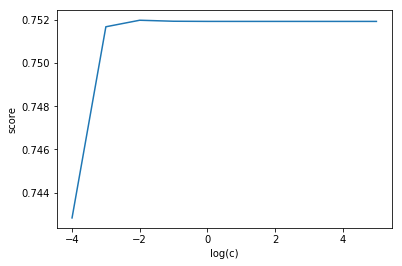

In [24]:
log_reg_scores = fit_log_reg(scaler.fit_transform(X_train_with_heroes_bag), y_train)
plot_scores(c_param_pows, log_reg_scores.values())

#### Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [25]:
print_max_log_reg_score(log_reg_scores)

C: 0.01, score: 0.7519704890317176


После добавления "мешка слов" по героям качество улучшилось. 
Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.75. 
Это объясняется тем, что вместо отсутствия данных о героях или случайного шума мы имеем осмысленную разреженную матрицу для построения предсказания.

#### 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [94]:
model = LogisticRegression(C = 0.01, random_state = 241)
model.fit(scaler.fit_transform(X_train_with_heroes_bag), y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=241, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [95]:
test_data = pd.read_csv('./data/features_test.csv', index_col = 'match_id')
test_data.fillna(0, inplace = True)
test_heroes_bag = hero_bag(test_data, heroes)
test_data_cleaned = clean_category(test_data)

scaler = StandardScaler()
X_test = scaler.fit_transform(pd.concat([test_data_cleaned, test_heroes_bag], axis = 1))

In [98]:
y_test = model.predict_proba(X_test)[:, 1]
result = pd.DataFrame({'radiant_win': y_test}, index = test_data.index)
result.index.name = 'match_id'

result.head()

,radiant_win
match_id,
6,0.822689
7,0.756018
10,0.188658
13,0.856746
16,0.241456


#### Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [103]:
'min score: {}, max score: {}'.format(result['radiant_win'].min(), result['radiant_win'].max())

'min score: 0.008705900769228144, max score: 0.996328715925428'

In [93]:
result.to_csv('./data/kaggle-final-result.csv')

Полученная модель получила оценку 0.68478 на Kaggle и позволила занять 2-е место, по состоянию на Apr 13 2019, 14:00